Rb Calculations

Preston Huft, May 2019.

https://docs.sympy.org/latest/modules/physics/wigner.html

sympy.physics.wigner.clebsch_gordan(j_1, j_2, j_3, m_1, m_2, m_3)[source], ⟨j1m1j2m2|j3m3⟩.
sympy.physics.wigner.wigner_3j(j_1, j_2, j_3, m_1, m_2, m_3)[source]
sympy.physics.wigner.wigner_6j(j_1, j_2, j_3, j_4, j_5, j_6, prec=None)[source]

In [1]:
# %matplotlib notebook
from matplotlib import pyplot as plt
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from sympy import symbols,N,sympify,lambdify
from sympy import MatrixSymbol,MatAdd,MatMul,Identity as eye,Matrix,zeros
from sympy.utilities.iterables import flatten
import numpy as np
from numpy import transpose,inf
from numpy.linalg import eig
import math as m
from math import sqrt,pi
from rbconsts import *
from physconsts import *
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

## functions

In [2]:
#### methods - much of these now live in amophys.py and have updated functionality 19/10/19

def hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,RME=None):
    """ Returns the matrix element <F,mF,J|T_q|F',mF',J'>. 
    
        RME is the reduced matrix element (just a number), which can be calculated
        externally and passed in to be a multiplier. If RME=None, the 
        matrix element is in units of [RME].
        
        I is the nuclear spin of the atom.
    """

    rme = 1
    if RME!=None:
        rme = RME

    ## From Mark's notes, eqs. A-50,51
    mat_elem = rme*pow(-1,F+JJ+1+I)*sqrt((2*F+1)*(2*JJ+1)) \
                *wigner_6j(J,I,F,FF,1,JJ) \
                *clebsch_gordan(1,F,FF,q,mF,mFF)
    
    return mat_elem

def eff_rabi(O,D):
    """ the effective two-photon rabi frequency, given a rabi freq O,
        where O1 = O2 = O, and single photon detuning D1 = D2 = D 
        from the transition frequency
    """
    return sqrt(O**2+D**2)

def jmbasis(jlist):
    """ returns a numpy array of basis vectors {|J,mJ>} given a list of 
        J vals"""
    basis = np.empty(sum([2*j+1 for j in jlist]),list)
    i = 0
    for j in jlist:
        for m in range(-j,j+1):
            basis[i] = [j,m]
            i+=1 
    return np.flip(basis)
#     basis = []
#     i = 0
#     for j in jlist:
#         for m in range(-j,j+1):
#             basis.append([j,m])
#     return np.flip(basis)

def cc(z):
    return np.conj(z)

## misc conversions

def radToTHz(w):
    return w/(2*pi*1e12)

def radToGHz(w):
    return w/(2*pi*1e9)

def radToMhz(w):
    return w/(2*pi*1e6)

def radTokHz(w):
    return w/(2*pi*1e3)

def JToeV(u):
    global ee
    return u/ee

def eVToJ(u):
    global ee
    return u*ee

def GHzToeV(nu):
    global hbar
    return JToeV(2*pi*hbar*nu*1e9)

def eVToGHz(u):
    global hbar
    return eVToJ(u)/(2*pi*hbar*1e9)

def mean_vrms(T):
    global kB,mRb
    return sqrt(kB*T/mRb)

# def alpha(w_ab,w,RME,I):
#     """ the polarizability of a two-level atom in an AC electric field
#     """
#     return 

In [3]:
###################################################################
# calculate 2 photon Rabi frequency for the ground state hyperfine 
# Raman transition
###################################################################

P = 3.5e-6 # [W] light power at experiment cell
a = 6e-6 # [m]
b = 8e-6 # [m], in y direction
A = a*b*pi # area at beam waist 
E0 = sqrt(4*P/(c*e0*A)) # the electric field amplitude
d = 2*pi*4.5e10 # [Hz] Single photon detuning

#       hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,RME=None):
O1 = E0*hf_matrix_elem(2,0,1/2,1,2,1,3/2,I,D2_MatElem)/hbar
O2 = E0*hf_matrix_elem(1,0,1/2,1,2,1,3/2,I,D2_MatElem)/hbar

# Ignoring a.c. stark shifts, etc:

# O1 /= 1e9 # [GHz]
# O2 /= 1e9 #
# print(N(O1),N(O2))

O = N(abs(O1*O2/(2*d))/1e3)/(2*pi) # [kHz]
print(f"Two-photon Rabi frequency = 2*pi*{O:.2f} kHz")

Two-photon Rabi frequency = 2*pi*284.24 kHz


In [4]:
## for the raman pulse notebook
o1 = hf_matrix_elem(2,0,1/2,1,2,1,3/2,I,D2_MatElem)
o2 = hf_matrix_elem(1,0,1/2,1,2,1,3/2,I,D2_MatElem)
print(N(o1),N(o2))

-1.79200000000000e-29 1.79200000000000e-29


In [5]:
###################################################################
# Differential AC Stark Shifts
###################################################################

def scalar_ls(w_ab,w,I,RME=None):
    """ the scalar AC Stark shift, or light shift, seen by a two 
        level atom in an oscillating electric field.
        w_ab is the freq difference between a,b
        w is the applied light frequency
        I is the intensity of the light 
        RME is the reduced matrix element <J||er||J'>.
    """
    
    if RME is None:
        RME = 1 # the light shift is now in units of the RME
    
    return -(ee**2)*w_ab*cc(RME)*RME*I/(2*hbar*(w_ab**2-w**2))

In [6]:
# The D2 line differential light shift of Rb87 in a far-off-resonance
# trap (FORT)

w0 = 2*pi*384.2304844685e12 # D2 line transition frequency
wFORT = 2*pi*c/(1064e-9)

waist = 2.5e-6 # gaussian waist of the FORT
P = .5 # [W] approx at center site (e.g. during PGC phase)
Int = P/(pi*waist**2)

In [7]:
radToTHz(wFORT)

281.7598289473684

In [8]:
###################################################################
# HF Zeeman Shifts
###################################################################

# Chris mentioned the quadrupole term.. I think I/Mark dropped that 

def gF_fn(F,J,I,gJ,gI):
    """ Returns the F lande g factor """
    
    return (gJ*(F*(F+1)+J*(J+1)-I*(I+1))
            +gI*(F*(F+1)-J*(J+1)+I*(I+1)))/(2*F*(F+1))

def gJ_fn(J,L,S,gL,gS):
    """ Returns the J lande g factor """

    return (gL*(J*(J+1)+L*(L+1)-S*(S+1)) 
            +gS*(J*(J+1)-L*(L+1)+S*(S+1)))/(2*J*(J+1))

def hf_zeeman(states,gJ,gI,Bz=None,units=None):
    """ From Mark's notes for the general hf Zeeman matrix elements. Units
        are determined by UB. Could implement decorator function to change
        units."""
    global muB # Bohr magneton
    UB = symbols('U_B') # assume symbolic B field P.E. for now

    if Bz is not None:
        UB = muB*Bz# magnetic field potential energy

    if units == 'UB':
        UB = 1
        
    I,J,F,mF,FF,mFF = states
    q = 0 # assume B = Bz for now
    
    elem = 0
    if mF == mFF:
        elem += N(clebsch_gordan(F,1,FF,mF,q,mFF) \
                *sqrt(2*F+1)*(-1)**(1+J+I) \
                *(gJ*(-1)**F*sqrt(J*(J+1)*(2*J+1)) \
                *wigner_6j(J,I,F,FF,1,J) \
                +gI*(-1)**FF*sqrt(I*(I+1)*(2*I+1)) \
                *wigner_6j(I,J,F,FF,1,I))) 
        # N() is used to ensure diagnolization doesn't get tripped up
    
    return UB*elem

# Rb87 ground state 5s1/2:
L = 0; S = 1/2; J = 1/2;
Flist = [2,1] # F = I + J
E_hf = GHzToeV(nu_hf)

gJ = gJ_fn(J,L,S,gL,gS)

Bzlist = np.linspace(0,.5,30)

E_hf = GHzToeV(nu_hf) # assign numeric value to ease diagonalization (?)

# Rb Hamiltonian for HF ground states in {|F,mF>} basis
H_a = E_hf*np.array([[1,0,0,0,0,0,0,0],
                     [0,1,0,0,0,0,0,0],
                     [0,0,1,0,0,0,0,0],
                     [0,0,0,1,0,0,0,0],
                     [0,0,0,0,1,0,0,0],
                     [0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0]],object)

# Zeeman Hamiltonian for B = Bz
H_Zz = np.empty((8,8),object)
basis = jmbasis(Flist)
for i,state_i in enumerate(basis):
        F,mF = state_i
        
        for j,state_j in enumerate(basis):
            FF,mFF = state_j
            states = [I,J,F,mF,FF,mFF]
            try:
                H_Zz[i,j] = hf_zeeman(states,gJ,gI)
            except:
                print("Failed: %s" % states)

# Diagonalize the full Hamiltonian
H = Matrix(H_a + H_Zz)
P,D = H.diagonalize()
evals = [D[i,i] for i in range(0,len(basis))]

# The energies as a function of magnetic P.E.
shifts = lambdify('U_B',evals)

zshifts = np.empty((len(Bzlist),len(basis)))
for i,Bz in enumerate(Bzlist):
    # make sure units of U_B same as E_hf then convert the whole shift
    zshifts[i] = np.sort([eVToGHz(x) for x in shifts(JToeV(uB*Bz))]) 
    
# arranged the shifts by state, not B value
zshifts = transpose(zshifts) 

In [9]:
basis

array([list([1, 1]), list([1, 0]), list([1, -1]), list([2, 2]),
       list([2, 1]), list([2, 0]), list([2, -1]), list([2, -2])],
      dtype=object)

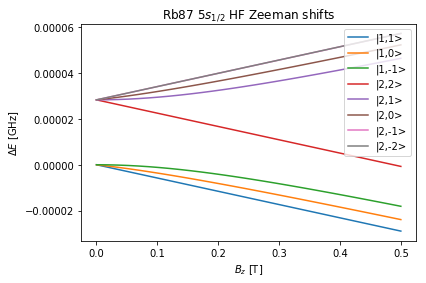

In [10]:
# initialize the figure and plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Rb87 $5s_{1/2}$ HF Zeeman shifts")
ax.set_xlabel("$B_z$ [T]")
ax.set_ylabel("$\Delta E$ [GHz]")

# why is the |2,-1> state omitted??
for state,shift in zip(basis,zshifts):
    F,mF = state
    ax.plot(Bzlist,GHzToeV(shift),label=f'|{F},{mF}>')

ax.legend(loc='upper right')
plt.show()

In [12]:
zshifts[7]

array([ 6.83468261,  7.07590462,  7.31712662,  7.55834863,  7.79957064,
        8.04079265,  8.28201465,  8.52323666,  8.76445867,  9.00568067,
        9.24690268,  9.48812469,  9.72934669,  9.9705687 , 10.21179071,
       10.45301271, 10.69423472, 10.93545673, 11.17667874, 11.41790074,
       11.65912275, 11.90034476, 12.14156676, 12.38278877, 12.62401078,
       12.86523278, 13.10645479, 13.3476768 , 13.58889881, 13.83012081])

In [10]:
## Differential Zeeman shifts of HF state for B ~ 1 G
Bzlist = np.linspace(-3e-4,3e-4,40)

E_hf = GHzToeV(nu_hf) # assign numeric value to ease diagonalization (?)

# Rb Hamiltonian for HF ground states in {|F,mF>} basis
H_a = E_hf*np.array([[1,0,0,0,0,0,0,0],
                     [0,1,0,0,0,0,0,0],
                     [0,0,1,0,0,0,0,0],
                     [0,0,0,1,0,0,0,0],
                     [0,0,0,0,1,0,0,0],
                     [0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0]],object)

# Zeeman Hamiltonian for B = Bz
H_Zz = np.empty((8,8),object)
basis = jmbasis(Flist)
for i,state_i in enumerate(basis):
        F,mF = state_i
        for j,state_j in enumerate(basis):
            FF,mFF = state_j
            states = [I,J,F,mF,FF,mFF]
            try:
                H_Zz[i,j] = hf_zeeman(states,gJ,gI)
            except:
                print("Failed: %s" % states)

# Diagonalize the full Hamiltonian
H = Matrix(H_a + H_Zz)
P,D = H.diagonalize()
evals = [D[i,i] for i in range(0,len(basis))]

# The energies as a function of magnetic P.E.
shifts = lambdify('U_B',evals)

zshifts = np.empty((len(Bzlist),len(basis)))
for i,Bz in enumerate(Bzlist):
    # make sure units of U_B same as E_hf then convert the whole shift
    zshifts[i] = [eVToGHz(x) for x in shifts(JToeV(uB*Bz))]
    
# arranged the shifts by state, not B value
zshifts = transpose(zshifts) 

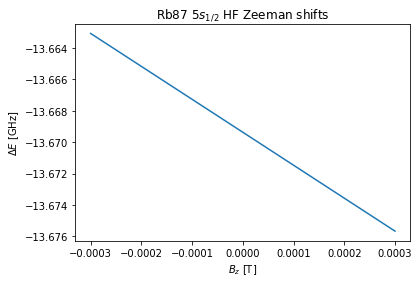

In [11]:
# initialize the figure and plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Rb87 $5s_{1/2}$ HF Zeeman shifts")
ax.set_xlabel("$B_z$ [T]")
ax.set_ylabel("$\Delta E$ [GHz]")

hf_dshift = zshifts[5]-zshifts[1]-nu_hf # differential Zeeman shift of hyperfine levels

ax.plot(Bzlist,hf_dshift) #,label=f"|{F},{mF}>") # shifts not in same order as basis... hmm 🤔
# ax.legend(loc='upper right')
plt.show()

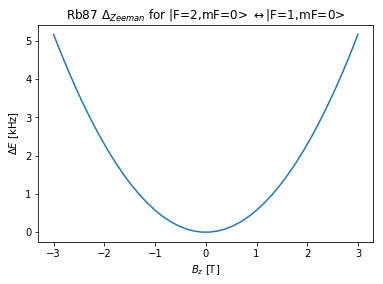

In [12]:
# initialize the figure and plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Rb87 $\Delta_{Zeeman}$ for |F=2,mF=0> $\leftrightarrow $|F=1,mF=0>")
ax.set_xlabel("$B_z$ [T]")
ax.set_ylabel("$\Delta E$ [kHz]")

hf_dshift = (zshifts[3]-nu_hf)-zshifts[2]
ax.plot(Bzlist/1e-4,hf_dshift/1e-6) #,label=f"|{F},{mF}>") # shifts not in same order as basis... hmm 🤔
# ax.legend(loc='upper right')
plt.show()

The differential Zeeman shift for the hyperfine states |F=2,mF=0>,|F=1,mF=0> is parabolic upwards in B, such that the microwave transition should reveal any magnetic field bias of order of a G, which is on par with our bias fields. 

In [13]:
eVToJ(GHzToeV(nu_hf))

4.528708567504789e-24

In [14]:
F = 1; 
FF = 2; 
mF = 0; 
mFF = 0;
I = 3/2
J = 1/2
q=0

states = I,J,F,mF,FF,mFF
hf_zeeman(states,gJ,gI)

1.0006125*U_B

In [15]:
gI

-0.000995

In [16]:
clebsch_gordan(F,FF,1,mF,mFF,0)

-sqrt(10)/5

In [17]:
wigner_6j(J,I,F,FF,1,J)

sqrt(3)/6

In [18]:
N(clebsch_gordan(F,1,FF,mF,q,mFF) \
                *(gJ*wigner_6j(J,I,F,FF,1,J) \
                +gI*wigner_6j(I,J,F,FF,1,I)))

0.471384569389669

In [19]:
clebsch_gordan(F,1,FF,mF,q,mFF)

sqrt(6)/3

In [20]:
E_hf

2.8265975866660623e-05

In [21]:
GHzToeV(nu_hf)*ee

4.528708567504789e-24

In [22]:
# pgc parameter
J = 1/2; JJ = 3/2
F = 2; FF = 3
mF = 0; mFF = 1
q = 1

# Kurtseifer group optimal parameters
p = (2.5e-4) # total
w0 = 1e-3
Int = p/(pi*w0**2)
D = -4.3*gamma_D2

# Rabi frequency squared
OSq = 2*hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,D2_MatElem)**2*Int/(c*e0*hbar**2)

OSq/(D*gamma_D2)

-0.443481695275236

In [29]:
# What we should have for optimal parameters
q=1
p = 1.4e-3 # total
w0 = 2e-3
Int = p/(pi*w0**2)
D = -5.9*gamma_D2

# Rabi frequency squared
OSq = 2*hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,D2_MatElem)**2*Int/(c*e0*hbar**2)

OSq/(D*gamma_D2)

-0.452501661958800

In [26]:
# Our pgc parameter ( 2019 )
q=1
p = 1.2e-3 # total
w0 = 1e-3 # chris thinks the beams are bigger... idk
Int = p/(pi*(.83e-3)**2)
D = -5*gamma_D2

# Rabi frequency squared
OSq = 2*hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,D2_MatElem)**2*Int/(c*e0*hbar**2)

OSq/(D*gamma_D2)

-2.65741390346375

In [5]:
mean_v(5e-5)

0.06974432411219107

In [26]:
del k
k = lambda d: (omega_D2+d*gamma_D2)/c # d is detuning in units lifetime

In [33]:
k(0)/gamma_D2

0.21135384395576617

In [37]:
gamma_D2/k(-5)

4.731402373361072

In [2]:
# rydberg lifetime (Urban thesis; Mark,Thad 2005)

tau_bb = lambda n,T: 3*hbar*n**2/(4*alpha**3*kB*T) # blackbody
tau_0 = lambda nstar,aL: 2.09e-9*nstar**aL # T=0 lifetime
aL = 2.85

In [5]:
# approx photoionization rate (Urban thesis)
gamma_pi = lambda U,n: U*(50/n)**3*(31000) # U [mK]

In [10]:
1/gamma_pi(1.4,84)

0.00010925419354838712

In [13]:
elip = lambda a,b: pi*a*b

In [16]:
# Urban thesis
r480area = elip(9.1e-6,10.5e-6)
r780Aarea = elip(7e-6,11.9e-6)
# r780Aarea = elip(7e-6,11.9e-6)

E = lambda P,A: sqrt(4*P/(c*e0*A)) # the electric field amplitude
print(E(26e-3,r480area),E(2e-6,r780Aarea))

361278.12892716326 3393.617102579731


In [70]:
ee**2/(16*pi*e0*kB*1000)

4.177369287583604e-09

In [12]:
## push beam power needed
sqrt(2*hbar*(omega_D2-2*gamma_D2)/mRb)

1894.144540534665

In [14]:
hbar*omega_D2/(mRb*c)

0.005983779041097417